<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd
import os
import gdown
import logging
from pathlib import Path
from io import StringIO
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler



### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 21.5MB/s]


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos




#### Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.

In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


#### Alumno: 

Observar como está distribuido el dataset respecto a la columna Rating es decir, observar que tan balanceado se encuentra respecto a cada clase

In [6]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecto a cada clase
balance_clases=df_reviews['Rating'].value_counts(normalize=True)
balance_clases


4    0.553862
3    0.216775
2    0.124685
1    0.068416
0    0.036262
Name: Rating, dtype: float64

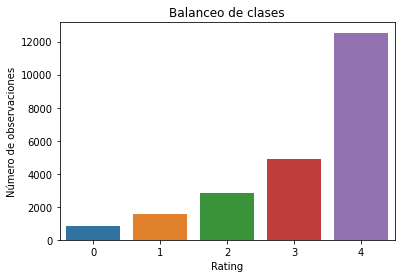

In [7]:
sns.countplot(x='Rating', data=df_reviews)
plt.title("Balanceo de clases")
plt.xlabel("Rating")
plt.ylabel("Número de observaciones");
plt.show()

Vemos que las clases están bastante desbalanceadas

#### Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

In [8]:
rating_reviews = df_reviews['Review Text'].values
print("Shape del vecotr de reviews: ",rating_reviews.shape)

Shape del vecotr de reviews:  (22641,)


#### Alumno: Cuantas reviews (rows) hay para evaluar?

In [9]:
print("Cantidad de reviews a evaluar: ",len(rating_reviews))

Cantidad de reviews a evaluar:  22641


In [10]:
print("Las primeras 5 reviews son: \n")
rating_reviews[:5]

Las primeras 5 reviews son: 



array(['Absolutely wonderful - silky and sexy and comfortable',
       'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
       'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
       "I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothi

#### Alumno: Concatenar todas las reviews para armar el corpus

In [11]:
corpus = ' '.join(rating_reviews)

#### Alumno: ¿Cuál es la longitud de ese corpus?

In [12]:
print("Longitud del corpus: ",len(corpus))

Longitud del corpus:  7011643


#### Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens

Recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase

In [13]:
tokens = text_to_word_sequence(corpus)

#### Alumno: Dar un vistazo a los primeros 20 tokens/palabras

In [14]:
print("Primeros 20 tokens:\n",tokens[:20])

Primeros 20 tokens:
 ['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable', 'love', 'this', 'dress', "it's", 'sooo', 'pretty', 'i', 'happened', 'to', 'find', 'it', 'in', 'a']


#### Alumno: ¿Cuántos tokens/palabras hay?

In [15]:
print("Cantidad de tokens: ",len(tokens))

Cantidad de tokens:  1372203


#### Alumno: Tokenizar las palabras con el Tokenizer de Keras

- Definir una máxima cantidad de palabras a utilizar: num_words 

In [16]:
num_words = 8000
vocab_size = num_words
tokenizador = Tokenizer(num_words=num_words)
tokenizador.fit_on_texts(tokens)

#### Alumno: Obtener el diccionario de palabra (word) a índice y observar la cantidad total del vocabulario

In [17]:
word_index = tokenizador.word_index
print("Cantidad total del vocabulario: ",len(word_index))

Cantidad total del vocabulario:  14847


#### Alumno: Convertir las palabras/tokens a números

In [18]:
reviews_nums = tokenizador.texts_to_sequences(rating_reviews)

In [19]:
print("Para el review: '",rating_reviews[0], "' su representación númerica es: ", reviews_nums[0])

Para el review: ' Absolutely wonderful - silky and sexy and comfortable ' su representación númerica es:  [253, 532, 917, 3, 662, 3, 68]


#### Alumno: Determinar cual es la oración más larga

In [20]:
long_max =max(len(s) for s in reviews_nums)
print("La oracion más larga tiene ",long_max, " palabras")

La oracion más larga tiene  116  palabras


#### Alumno: Realizar padding de las sentencias al mismo tamaño tomando de referencia la máxima sentencia

In [21]:
 X = pad_sequences(reviews_nums, padding='pre', maxlen=long_max)

#### Alumno: Observar las dimensiones de la variable input

In [22]:
print("Dimensiones de la variable input(x): ",X.shape)

Dimensiones de la variable input(x):  (22641, 116)


#### Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad de clases que se deseen predecir (en este ejemplo son 5)

In [23]:
y = to_categorical(df_reviews['Rating'].values)

In [24]:
print("Dimensiones de la variable output(y): ",y.shape)

Dimensiones de la variable output(y):  (22641, 5)


In [26]:
#smt = SMOTE(random_state=0)
#X, y = smt.fit_resample(X, y)
oversampler = RandomOverSampler(sampling_strategy="all")
X, y = oversampler.fit_resample(X, y)


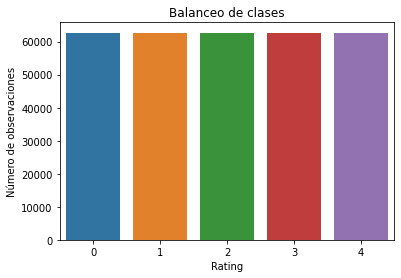

In [30]:
sns.countplot(data=y)#, data=y)
plt.title("Balanceo de clases")
plt.xlabel("Rating")
plt.ylabel("Número de observaciones");
plt.show()



#### Alumno: Dividir los datos en train y test

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

#### Alumno: determinar la dimensiones de entrada y salida

In [32]:
in_shape = X.shape[1]
out_shape = y.shape[1]
print("Dimensiones de entrada: ",in_shape)
print("Dimensiones de salida: ",out_shape)

Dimensiones de entrada:  116
Dimensiones de salida:  5


### 2 - Entrenar el modelo con Embeddings + LSTM

#### Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings o utilizando embeddings pre-entrenados.

#### 2.1 - Entrenar el modelo con Embeddings + LSTM con embedings propios

##### Generamos nuestro modelo 1

El mismo consta de:

* Capa de embedings con tamaño de embeding de 50
* Capa LSTM de 64 unidades 
* Capa LSTM de 128 unidades
* Capa densa de 64 unidades
* Capa densa final con activación Softmax y tamaño de salida de 5 (5 clases)

In [33]:
model = Sequential()
tam_embed = 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=tam_embed, input_length=in_shape))
model.add((LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(units=128)) 

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 116, 50)           400050    
                                                                 
 lstm (LSTM)                 (None, 116, 64)           29440     
                                                                 
 dropout (Dropout)           (None, 116, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 3

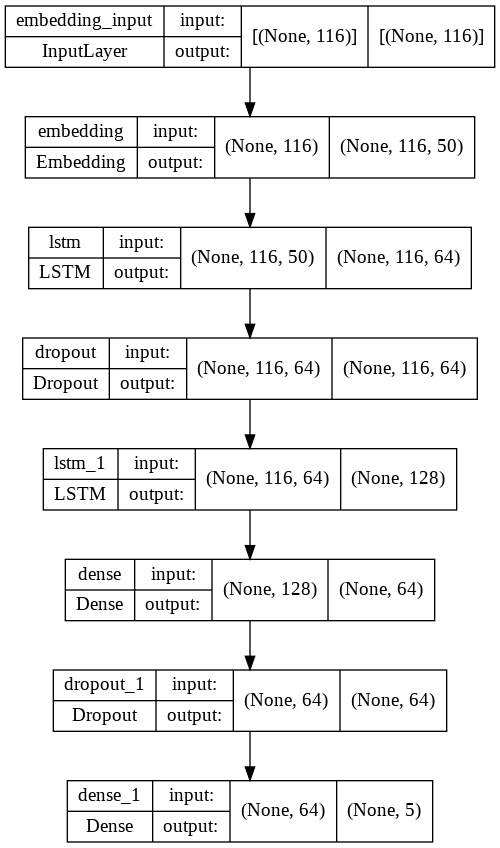

In [34]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [35]:
epochs = 60 
hist = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2)

Epoch 1/60
1254/1254 [==============================] - 27s 15ms/step - loss: 1.0807 - accuracy: 0.5146 - val_loss: 0.8132 - val_accuracy: 0.6623
Epoch 2/60
1254/1254 [==============================] - 20s 16ms/step - loss: 0.6794 - accuracy: 0.7239 - val_loss: 0.6741 - val_accuracy: 0.7272
Epoch 3/60
1254/1254 [==============================] - 18s 15ms/step - loss: 0.5035 - accuracy: 0.8056 - val_loss: 0.5351 - val_accuracy: 0.7976
Epoch 4/60
1254/1254 [==============================] - 19s 15ms/step - loss: 0.4010 - accuracy: 0.8480 - val_loss: 0.4820 - val_accuracy: 0.8271
Epoch 5/60
1254/1254 [==============================] - 19s 15ms/step - loss: 0.3290 - accuracy: 0.8799 - val_loss: 0.4567 - val_accuracy: 0.8376
Epoch 6/60
1254/1254 [==============================] - 18s 14ms/step - loss: 0.2813 - accuracy: 0.8982 - val_loss: 0.4423 - val_accuracy: 0.8531
Epoch 7/60
1254/1254 [==============================] - 19s 15ms/step - loss: 0.2417 - accuracy: 0.9147 - val_loss: 0.4134 -

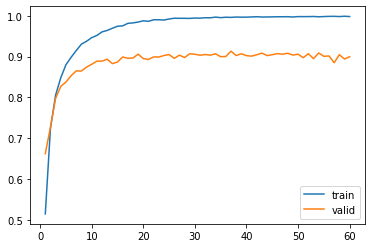

In [36]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [37]:
model.evaluate(X_test, y_test)

392/392 [==============================] - 3s 7ms/step - loss: 0.8856 - accuracy: 0.9081


[0.8855710029602051, 0.9081339836120605]

##### Generamos nuestro modelo 2

El mismo consta de:

* Capa de embedings con tamaño de embeding de 100
* 2 Capas LSTM de 64 unidades 
* Capa densa de 32 unidades
* Capa densa final con activación Softmax y tamaño de salida de 5 (5 clases)

In [38]:
model2 = Sequential()
tam_embed = 100

model2.add(Embedding(input_dim=vocab_size+1, output_dim=tam_embed, input_length=in_shape))
model2.add((LSTM(units=64, return_sequences=True)))
model2.add(Dropout(0.2))
model2.add((LSTM(units=64)))

model2.add(Dense(units=32, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='softmax'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 116, 100)          800100    
                                                                 
 lstm_2 (LSTM)               (None, 116, 64)           42240     
                                                                 
 dropout_2 (Dropout)         (None, 116, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                

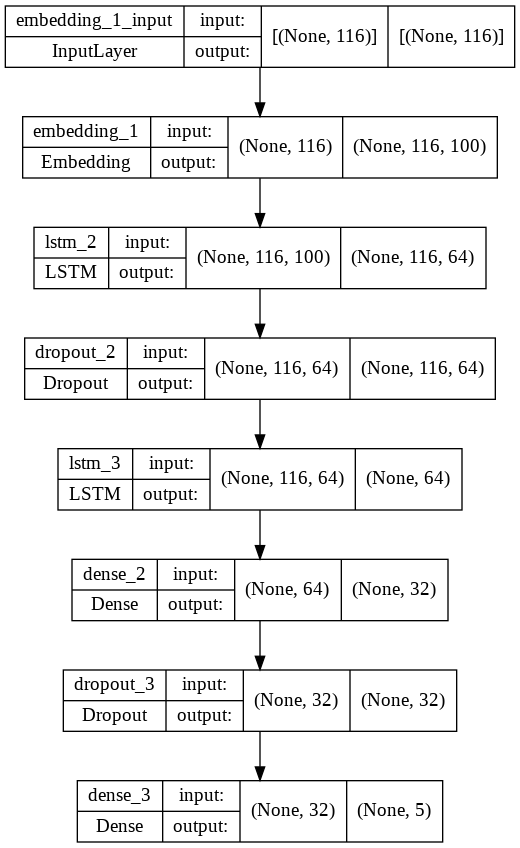

In [39]:
plot_model(model2, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

In [40]:
hist2 = model2.fit(X_train, y_train, epochs=epochs, validation_split=0.2)

Epoch 1/60
1254/1254 [==============================] - 19s 13ms/step - loss: 1.0464 - accuracy: 0.5419 - val_loss: 0.8601 - val_accuracy: 0.6374
Epoch 2/60
1254/1254 [==============================] - 17s 13ms/step - loss: 0.6523 - accuracy: 0.7396 - val_loss: 0.5913 - val_accuracy: 0.7672
Epoch 3/60
1254/1254 [==============================] - 16s 13ms/step - loss: 0.4723 - accuracy: 0.8209 - val_loss: 0.5010 - val_accuracy: 0.8151
Epoch 4/60
1254/1254 [==============================] - 16s 13ms/step - loss: 0.3674 - accuracy: 0.8654 - val_loss: 0.4597 - val_accuracy: 0.8286
Epoch 5/60
1254/1254 [==============================] - 16s 13ms/step - loss: 0.2965 - accuracy: 0.8921 - val_loss: 0.4509 - val_accuracy: 0.8452
Epoch 6/60
1254/1254 [==============================] - 16s 13ms/step - loss: 0.2487 - accuracy: 0.9126 - val_loss: 0.4303 - val_accuracy: 0.8609
Epoch 7/60
1254/1254 [==============================] - 17s 13ms/step - loss: 0.2132 - accuracy: 0.9273 - val_loss: 0.4233 -

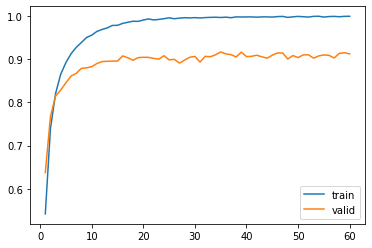

In [41]:
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [42]:
model2.evaluate(X_test, y_test)

392/392 [==============================] - 3s 7ms/step - loss: 0.9351 - accuracy: 0.9096


[0.93513423204422, 0.909649133682251]

En ambos modelos se obtuvieron resultado similares. En train se obtuvieron muy buenos valores, pero entramos en overfitting dado que en validación los resultados fueron bastante menores. 

A continuación probaremos con embeddding pre-entrenados para ver la performance.

#### 2.2 - Entrenar el modelo con Embeddings + LSTM con embedings pre-entrenados

##### Vamos a descargar los embeddings de fasttext para utilizar en nuestro modelo

In [43]:
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Downloading...
From: https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:31<00:00, 90.9MB/s]


##### Generamos la funcion para leer los embeddings

In [44]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

##### Generamos la matriz de embeddings

In [45]:
model_fasttext = FasttextEmbeddings()

In [46]:
print('Preparamos la matriz de embeddings...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(num_words, len(word_index)) 
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)
        print(word)

print('Numemro de word embeddings nulos:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparamos la matriz de embeddings...
Numemro de word embeddings nulos: 2


##### Generamos nuestro modelo similar al modelo 1 pero con embeddings pre-entrenados

El mismo consta de:

* Capa de embedings pre-entranada de longitud 300
* Capa LSTM de 64 unidades 
* Capa LSTM de 128 unidades
* Capa densa de 64 unidades
* Capa densa final con activación Softmax y tamaño de salida de 5 (5 clases)

In [47]:
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model3.add((LSTM(units=64, return_sequences=True)))
model3.add(Dropout(0.2))
model3.add(LSTM(units=128)) 

model3.add(Dense(units=64, activation='relu'))
model3.add(Dropout(rate=0.2))
model3.add(Dense(units=out_shape, activation='softmax'))

model3.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 116, 300)          2400000   
                                                                 
 lstm_4 (LSTM)               (None, 116, 64)           93440     
                                                                 
 dropout_4 (Dropout)         (None, 116, 64)           0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               98816     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 5)                

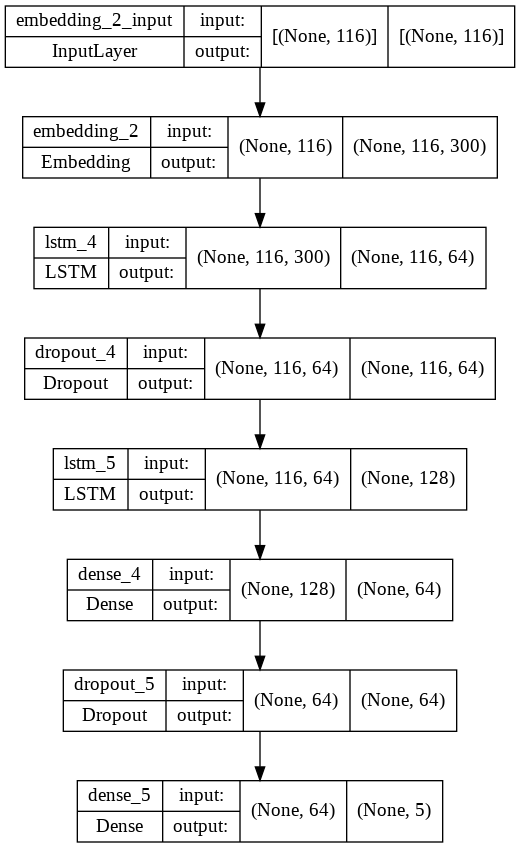

In [48]:
plot_model(model3, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [49]:
hist3 = model3.fit(X_train, y_train, epochs=epochs, validation_split=0.2)

Epoch 1/60
1254/1254 [==============================] - 22s 16ms/step - loss: 1.5485 - accuracy: 0.2820 - val_loss: 1.4776 - val_accuracy: 0.3321
Epoch 2/60
1254/1254 [==============================] - 18s 14ms/step - loss: 1.4022 - accuracy: 0.3803 - val_loss: 1.3017 - val_accuracy: 0.4330
Epoch 3/60
1254/1254 [==============================] - 18s 14ms/step - loss: 1.1604 - accuracy: 0.5069 - val_loss: 1.0838 - val_accuracy: 0.5462
Epoch 4/60
1254/1254 [==============================] - 18s 14ms/step - loss: 0.9194 - accuracy: 0.6119 - val_loss: 0.8378 - val_accuracy: 0.6400
Epoch 5/60
1254/1254 [==============================] - 18s 14ms/step - loss: 0.7643 - accuracy: 0.6755 - val_loss: 0.7874 - val_accuracy: 0.6707
Epoch 6/60
1254/1254 [==============================] - 19s 15ms/step - loss: 0.6654 - accuracy: 0.7179 - val_loss: 0.6860 - val_accuracy: 0.7137
Epoch 7/60
1254/1254 [==============================] - 18s 14ms/step - loss: 0.5893 - accuracy: 0.7487 - val_loss: 0.6078 -

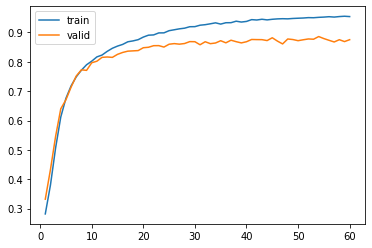

In [50]:
epoch_count = range(1, len(hist3.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist3.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist3.history['val_accuracy'], label='valid')
plt.show()

In [51]:
model3.evaluate(X_test, y_test)

392/392 [==============================] - 3s 7ms/step - loss: 0.5761 - accuracy: 0.8719


[0.5760506391525269, 0.8718500733375549]

##### Generamos nuestro modelo similar al modelo 2 pero con embeddings pre-entrenados

El mismo consta de:

* Capa de embedings pre-entranada de longitud 300
* 2 Capas LSTM de 64 unidades 
* Capa densa de 32 unidades
* Capa densa final con activación Softmax y tamaño de salida de 5 (5 clases)

In [52]:
model4 = Sequential()
model4.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))
model4.add((LSTM(units=64, return_sequences=True)))
model4.add(Dropout(0.2))
model4.add((LSTM(units=64)))
model4.add(Dense(units=32, activation='relu'))
model4.add(Dropout(rate=0.2))
model4.add(Dense(units=out_shape, activation='softmax'))

model4.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 116, 300)          2400000   
                                                                 
 lstm_6 (LSTM)               (None, 116, 64)           93440     
                                                                 
 dropout_6 (Dropout)         (None, 116, 64)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 5)                

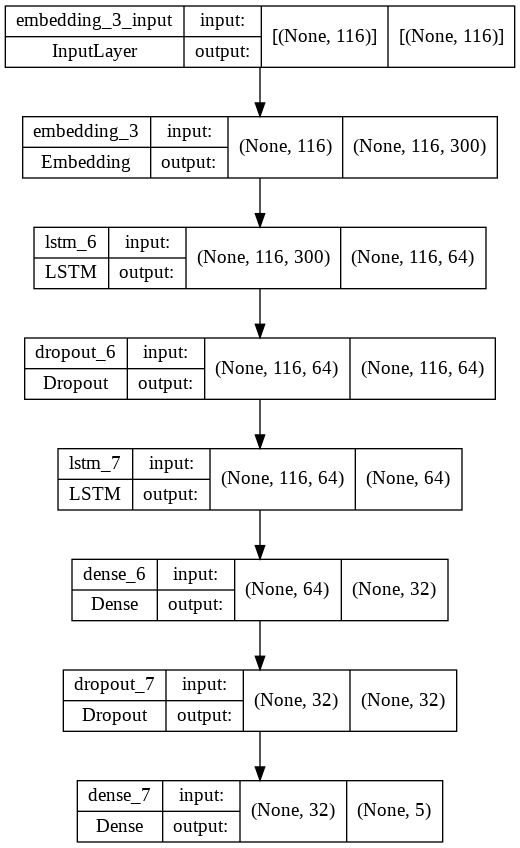

In [53]:
plot_model(model4, to_file='model_plot4.png', show_shapes=True, show_layer_names=True)

In [54]:
hist4 = model4.fit(X_train, y_train, epochs=epochs, validation_split=0.2)

Epoch 1/60
1254/1254 [==============================] - 20s 14ms/step - loss: 1.5584 - accuracy: 0.2691 - val_loss: 1.4956 - val_accuracy: 0.3181
Epoch 2/60
1254/1254 [==============================] - 17s 13ms/step - loss: 1.4206 - accuracy: 0.3693 - val_loss: 1.3368 - val_accuracy: 0.4191
Epoch 3/60
1254/1254 [==============================] - 17s 13ms/step - loss: 1.2346 - accuracy: 0.4703 - val_loss: 1.1375 - val_accuracy: 0.5137
Epoch 4/60
1254/1254 [==============================] - 17s 14ms/step - loss: 1.0405 - accuracy: 0.5556 - val_loss: 0.9948 - val_accuracy: 0.5765
Epoch 5/60
1254/1254 [==============================] - 17s 13ms/step - loss: 0.9049 - accuracy: 0.6099 - val_loss: 0.9078 - val_accuracy: 0.6071
Epoch 6/60
1254/1254 [==============================] - 16s 13ms/step - loss: 0.8131 - accuracy: 0.6496 - val_loss: 0.8149 - val_accuracy: 0.6488
Epoch 7/60
1254/1254 [==============================] - 17s 13ms/step - loss: 0.7422 - accuracy: 0.6803 - val_loss: 0.7430 -

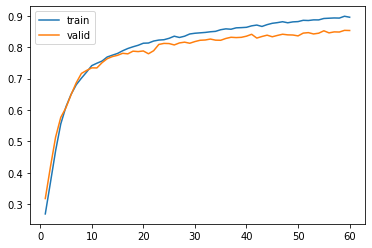

In [55]:
epoch_count = range(1, len(hist4.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist4.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist4.history['val_accuracy'], label='valid')
plt.show()

In [56]:
model4.evaluate(X_test, y_test)

392/392 [==============================] - 2s 6ms/step - loss: 0.4497 - accuracy: 0.8565


[0.4497276544570923, 0.8565390706062317]

#### Conclusiones

Los resultados fueron similares con ambos modelos, del orden del 90% en test para el caso de embedding sin entrenamiento previo y 86% para los embedding pre-entrenados.

Los modelos con embedding pre-entrenados tuvieron resultados algo menores, pero su tiempo de entrenamiento fue  menor.

Los puntos a destacar son:

* Con modelos más simples y menos profundos se lograron mejores resultados que la notebook anterior.
* Con los embeddings pre-entrenados de fastex los tiempos de entrenamiento fueron menores, pero los resultados obtenidos fueron algo peores. Se vio que entrenar los embeddings considerando el contexto propio del problema ayudó a tener mejores resultados, aún cuando la longitud de los embeddings fueron menores (Ventajas: mejores resultados y embeddings más pequeños).
* Con el oversampling se pudo mejorar mucho la performance final. Fue fundamental el correcto preprocesamiento de los datos y entendimiento y análisis del problema y los datos.